<a href="https://colab.research.google.com/github/jtkernan7/DS-Unit-2-Regression-2/blob/master/JT_Copy_of_permutation_importances_partial_dependence_plots_LIVE_LESSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Regression 2_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Permutation Importances, Partial Dependence Plots


#### Objectives
- Get and interpret permutation importances
- Visualize and interpret partial dependence plots

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding): `conda install -c conda-forge category_encoders` / `pip install category_encoders`

In [0]:
!pip install eli5 pdpbox category_encoders

### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas didn't work. The bug seems to be fixed now, but if you have problems, [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

4. With PDPBox version <= 0.20, using the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works. [This issue](https://github.com/SauceCat/PDPbox/issues/40) will be fixed in the next release of PDPbox.

**[(Data science is often about putting square pegs in round holes!)](https://www.youtube.com/watch?v=ry55--J4_VQ)**

### Two types of model explanations today:

#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

### Third type of model explanation next week:

#### 3. Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Get data


#### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


#### Option 2. Kaggle API

Follow these [instructions](https://github.com/Kaggle/kaggle-api).

#### Option 3. Google Drive

Download [zip file](https://drive.google.com/uc?export=download&id=1oGky3xR6133pub7S4zIEFbF4x1I87jvC) from Google Drive.

In [0]:
# from google.colab import files
# files.upload()

In [0]:
# !unzip caterpillar-tube-pricing.zip

In [0]:
# !unzip data.zip

# Example solution for last assignment 🚜

***We considered some questions about this relational data...***

### `bill_of_materials`

is formatted like this:

In [0]:
import pandas as pd
materials = pd.read_csv('competition_data/bill_of_materials.csv')
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Would this be a better representation?

Could pandas melt, crosstab, and other functions help reshape the data like this?

| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

### `components`

Contains three representations of each component, in order of decreasing cardinality / granularity:

- `component_id`
- `name`
- `component_type_id`

What are the pros & cons of these different representations?

In [0]:
components = pd.read_csv('competition_data/components.csv')
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-1569,FLANGE,OTHER
freq,1,350,1006


***Here's how we could do some of this data wrangling...***

### 1a. Get a tidy list of the component id's in each tube assembly

In [0]:
import pandas as pd
materials = pd.read_csv('competition_data/bill_of_materials.csv')

assembly_components = materials.melt(id_vars='tube_assembly_id', 
                                     value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'}))

assembly_components.head(10)

,tube_assembly_id,variable,component_id
0,TA-00001,component_id_1,C-1622
21198,TA-00001,component_id_2,C-1629
1,TA-00002,component_id_1,C-1312
2,TA-00003,component_id_1,C-1312
3,TA-00004,component_id_1,C-1312
4,TA-00005,component_id_1,C-1624
42400,TA-00005,component_id_3,C-1641
21202,TA-00005,component_id_2,C-1631
5,TA-00006,component_id_1,C-1624
21203,TA-00006,component_id_2,C-1631


### 1b. Merge with component types

In [0]:
components = pd.read_csv('competition_data/components.csv')
assembly_component_types = assembly_components.merge(components, how='left')
assembly_component_types.head(10)

,tube_assembly_id,variable,component_id,name,component_type_id
0,TA-00001,component_id_1,C-1622,NUT-SWIVEL,CP-025
1,TA-00001,component_id_2,C-1629,SLEEVE-ORFS,CP-024
2,TA-00002,component_id_1,C-1312,NUT-FLARED,CP-028
3,TA-00003,component_id_1,C-1312,NUT-FLARED,CP-028
4,TA-00004,component_id_1,C-1312,NUT-FLARED,CP-028
5,TA-00005,component_id_1,C-1624,NUT-SWIVEL,CP-025
6,TA-00005,component_id_3,C-1641,CONNECTOR-SEAL,CP-014
7,TA-00005,component_id_2,C-1631,SLEEVE-ORFS,CP-024
8,TA-00006,component_id_1,C-1624,NUT-SWIVEL,CP-025
9,TA-00006,component_id_2,C-1631,SLEEVE-ORFS,CP-024


### 1c. Make a crosstab of the component types for each assembly (one-hot encoding)

In [0]:
table = pd.crosstab(assembly_component_types['tube_assembly_id'], 
                    assembly_component_types['component_type_id'])

table = table.reset_index()
table.columns.name = ''
print(table.shape)
table.head()

(19149, 30)


,tube_assembly_id,CP-001,CP-002,CP-003,CP-004,CP-005,CP-006,CP-007,CP-008,CP-009,CP-010,CP-011,CP-012,CP-014,CP-015,CP-016,CP-017,CP-018,CP-019,CP-020,CP-021,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER
0,TA-00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,TA-00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,TA-00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,TA-00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,TA-00005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


### 2a. Most of the component files have a "weight" feature:

In [0]:
from glob import glob
import pandas as pd

def search_column(name):
    for path in glob('competition_data/*.csv'):
        df = pd.read_csv(path)
        if name in df.columns:
            print(path, df.shape)
            print(df.columns.tolist(), '\n')

search_column('weight')

competition_data/comp_nut.csv (65, 11)
['component_id', 'component_type_id', 'hex_nut_size', 'seat_angle', 'length', 'thread_size', 'thread_pitch', 'diameter', 'blind_hole', 'orientation', 'weight'] 

competition_data/comp_elbow.csv (178, 16)
['component_id', 'component_type_id', 'bolt_pattern_long', 'bolt_pattern_wide', 'extension_length', 'overall_length', 'thickness', 'drop_length', 'elbow_angle', 'mj_class_code', 'mj_plug_class_code', 'plug_diameter', 'groove', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_boss.csv (147, 15)
['component_id', 'component_type_id', 'type', 'connection_type_id', 'outside_shape', 'base_type', 'height_over_tube', 'bolt_pattern_long', 'bolt_pattern_wide', 'groove', 'base_diameter', 'shoulder_diameter', 'unique_feature', 'orientation', 'weight'] 

competition_data/comp_hfl.csv (6, 9)
['component_id', 'component_type_id', 'hose_diameter', 'corresponding_shell', 'coupling_class', 'material', 'plating', 'orientation', 'weight'] 

competit

### 2b. Most of the component files have "orientation" & "unique_feature" binary features

In [0]:
comp_threaded = pd.read_csv('competition_data/comp_threaded.csv')
comp_threaded['orientation'].value_counts()

No     121
Yes     73
Name: orientation, dtype: int64

In [0]:
comp_threaded['unique_feature'].value_counts()

No     161
Yes     33
Name: unique_feature, dtype: int64

### 2c. Read all the component files and concatenate them together

In [0]:
comp = pd.concat((pd.read_csv(path) for path in glob('competition_data/comp_*.csv')), sort=False)
columns = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[columns]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

In [0]:
comp.head()

,component_id,component_type_id,orientation,unique_feature,weight
0,C-1621,CP-025,0,0,0.015
1,C-1624,CP-025,0,0,0.035
2,C-1623,CP-025,0,0,0.044
3,C-1622,CP-025,0,0,0.036
4,C-1625,CP-025,0,0,0.129


### 2d. Engineer features, aggregated for all components in a tube assembly
- Components total
- Components distinct
- Orientation 
- Unique Feature
- Weight

In [0]:
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0)  for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, left_on=f'component_id_{n}', right_on='component_id', 
                                how='left', suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,orientation,unique_feature,weight,component_id,component_type_id,orientation_1,unique_feature_1,weight_1,component_id_2,component_type_id_2,orientation_2,unique_feature_2,weight_2,component_id_3,component_type_id_3,orientation_3,unique_feature_3,weight_3,component_id_4,component_type_id_4,orientation_4,unique_feature_4,weight_4,component_id_5,component_type_id_5,orientation_5,unique_feature_5,weight_5,component_id_6,component_type_id_6,orientation_6,unique_feature_6,weight_6,component_id_7,component_type_id_7,orientation_7,unique_feature_7,weight_7,component_id_8,component_type_id_8,orientation_8,unique_feature_8,weight_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,0.0,1.0,0.048,C-1622,CP-025,0.0,0.0,0.036,C-1629,CP-024,0.0,1.0,0.012,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,0.0,0.0,0.009,C-1312,CP-028,0.0,0.0,0.009,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.000,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,0.0,1.0,0.210,C-1624,CP-025,0.0,0.0,0.035,C-1631,CP-024,0.0,1.0,0.026,C-1641,CP-014,0.0,0.0,0.149,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [0]:
features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]
print(materials.shape)
materials.head()

(21198, 7)


,tube_assembly_id,orientation,unique_feature,weight,components_total,components_distinct,component_id_1
0,TA-00001,0.0,1.0,0.048,4.0,2,C-1622
1,TA-00002,0.0,0.0,0.009,2.0,1,C-1312
2,TA-00003,0.0,0.0,0.009,2.0,1,C-1312
3,TA-00004,0.0,0.0,0.009,2.0,1,C-1312
4,TA-00005,0.0,1.0,0.210,3.0,3,C-1624


### 3. Read tube data

In [0]:
tube = pd.read_csv('competition_data/tube.csv')
tube.head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


### 4. Merge all this data with train, validation, and test sets

In [0]:
from sklearn.model_selection import train_test_split

# Read data
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge data
    X = (X.merge(table, how='left')
         .merge(materials, how='left')
         .merge(tube, how='left')
         .fillna(0))
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

### 5. Arrange X matrix and y vector (log-transformed)

In [0]:
import numpy as np

target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

### 6. Use xgboost to fit and evaluate model

In [0]:
import category_encoders as ce
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]
model = XGBRegressor(n_estimators=2000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[16:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71966	validation_1-rmse:1.70913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.56462	validation_1-rmse:1.55419
[2]	validation_0-rmse:1.42742	validation_1-rmse:1.41758
[3]	validation_0-rmse:1.30251	validation_1-rmse:1.29309
[4]	validation_0-rmse:1.19029	validation_1-rmse:1.18093
[5]	validation_0-rmse:1.09307	validation_1-rmse:1.08376
[6]	validation_0-rmse:1.00384	validation_1-rmse:0.994622
[7]	validation_0-rmse:0.925172	validation_1-rmse:0.916505
[8]	validation_0-rmse:0.856916	validation_1-rmse:0.849009
[9]	validation_0-rmse:0.794484	validation_1-rmse:0.786692
[10]	validation_0-rmse:0.741354	validation_1-rmse:0.734697
[11]	validation_0-rmse:0.693082	validation_1-rmse:0.686452
[12]	validation_0-rmse:0.6526

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

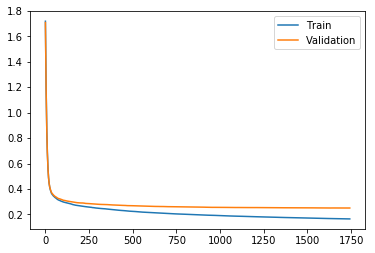

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();

### 7. Generate submission for Kaggle

Scores for this submission:

- Public: 0.26083
- Private: 0.28639

In [0]:
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
X_test_encoded = encoder.transform(X_test)
generate_submission(model, X_test_encoded, 'submission.csv')

# MODEL INTERPRETATION

## 1a. Feature Importances
- Global explanation: all features in relation to each other
- Default, fastest, good for first estimates

[Here's some food for thought](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) about feature importances:

>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

For more information, see [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html).

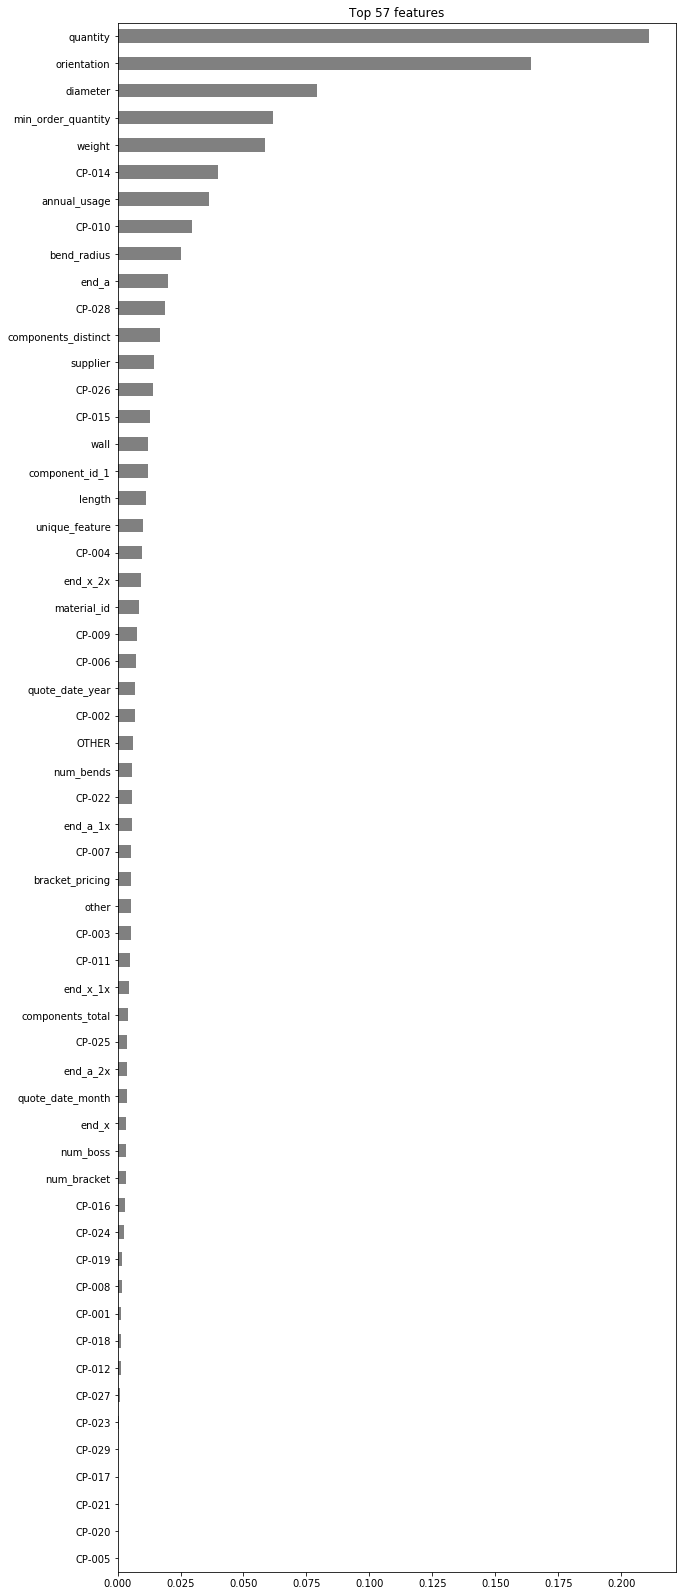

In [0]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_train_encoded.columns)

# Plot feature importances
n = len(X_train_encoded.columns)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## 1b. Drop-Column Importance
- Global explanation: all features in relation to each other
- The best in theory, but much too slow in practice

In [0]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

column  = 'annual_usage'

# Fit without column
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded.drop(columns=column), y_train_log)
y_pred_log = model.predict(X_val_encoded.drop(columns=column))
score_without = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE without {column}:', score_without)

# Fit with column
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_val_encoded)
score_with = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE with {column}:', score_with)

# Compare the error with & without column
print(f'Drop-Column Importance for {column}:', score_without - score_with)

[16:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE without annual_usage: 0.29504414664740464
[16:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE with annual_usage: 0.25572291814478654
Drop-Column Importance for annual_usage: 0.0393212285026181
CPU times: user 1min 39s, sys: 175 ms, total: 1min 40s
Wall time: 50.4 s


## 1c. Permutation Importance
- Global explanation: all features in relation to each other
- A good compromise!

Permutation Importance is a compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [0]:
feature = 'quantity'
X_val_encoded[feature].head()

0     1
1     2
2     5
3    10
4    25
Name: quantity, dtype: int64

In [0]:
X_val_encoded[feature].describe()

count    7585.000000
mean       38.752406
std        69.092613
min         1.000000
25%         2.000000
50%        10.000000
75%        50.000000
max       600.000000
Name: quantity, dtype: float64

In [0]:
X_val_permuted = X_val_encoded.copy()
X_val_permuted[feature] = np.random.permutation(X_val_encoded[feature])
X_val_permuted[feature].head()

0    10
1    25
2    50
3     1
4    25
Name: quantity, dtype: int64

In [0]:
X_val_permuted['quantity'].describe()

count    7585.000000
mean       38.752406
std        69.092613
min         1.000000
25%         2.000000
50%        10.000000
75%        50.000000
max       600.000000
Name: quantity, dtype: float64

In [0]:
y_pred_log = model.predict(X_val_permuted)
score_permuted = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE with {feature}:', score_with)
print(f'Validation RMSLE with {feature} permuted:', score_permuted)
print(f'Permutation Importance:', score_permuted - score_with)

Validation RMSLE with quantity: 0.25572291814478654
Validation RMSLE with quantity permuted: 0.893292404097707
Permutation Importance: 0.6375694859529205


In [0]:
feature = 'annual_usage'
X_val_permuted = X_val_encoded.copy()
X_val_permuted[feature] = np.random.permutation(X_val_encoded[feature])
y_pred_log = model.predict(X_val_permuted)
score_permuted = rmse(y_val_log, y_pred_log)
print(f'Validation RMSLE with {feature}:', score_with)
print(f'Validation RMSLE with {feature} permuted:', score_permuted)
print(f'Permutation Importance:', score_permuted - score_with)

Validation RMSLE with annual_usage: 0.25572291814478654
Validation RMSLE with annual_usage permuted: 0.36130321350504996
Permutation Importance: 0.10558029536026342


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)
- [scikit-learn user guide, `scoring` parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.7328 ± 0.0040,quantity
0.2511 ± 0.0029,min_order_quantity
0.0641 ± 0.0016,annual_usage
0.0501 ± 0.0048,supplier
0.0432 ± 0.0009,diameter
0.0413 ± 0.0008,weight
0.0332 ± 0.0018,quote_date_year
0.0189 ± 0.0027,length
0.0107 ± 0.0005,wall
0.0082 ± 0.0009,component_id_1


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [0]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (22628, 57)


In [0]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_val = X_val[features]

Shape after removing features: (22628, 45)


In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_val_encoded)
print(f'Validation RMSLE', rmse(y_val_log, y_pred_log))

[17:25:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation RMSLE 0.2542001381940627


## 2. Partial Dependence Plots

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

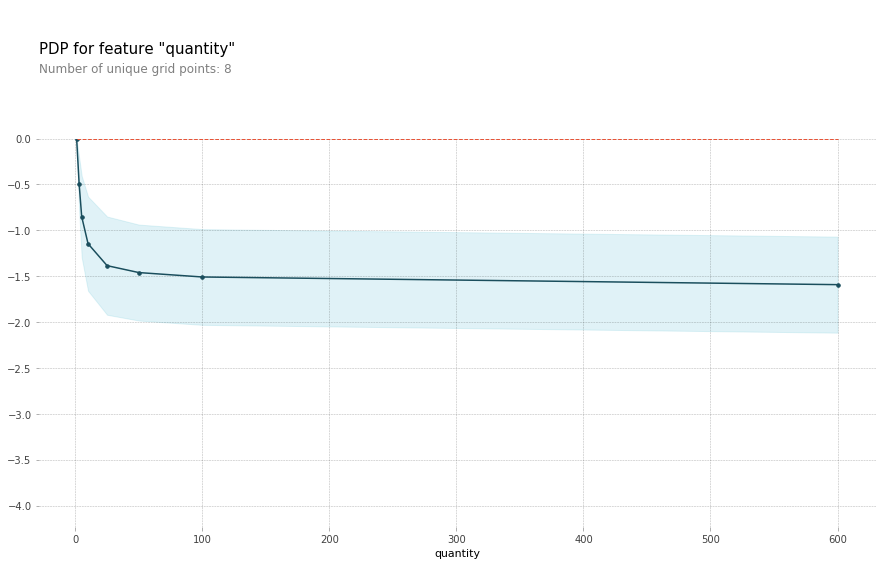

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'quantity'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

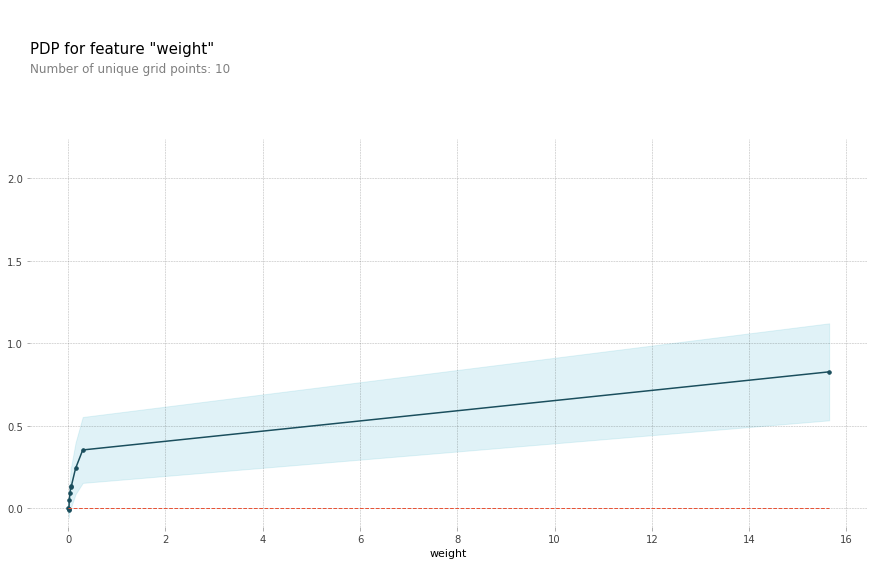

In [0]:
feature = 'weight'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

### Explaining Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

### Partial Dependence Plots with 2 features, to see interactions

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdpbox.pdp.pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

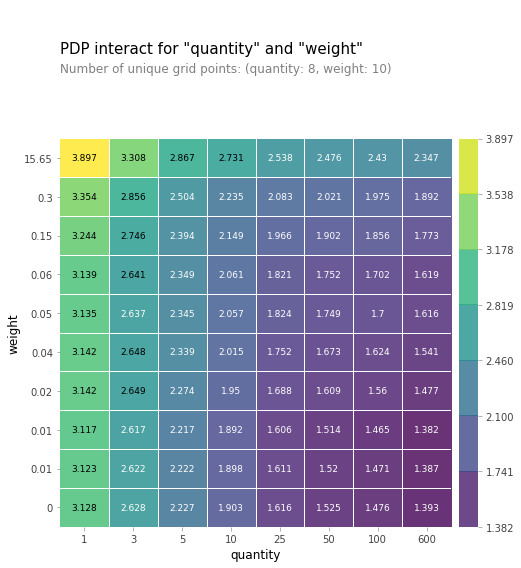

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['quantity', 'weight']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

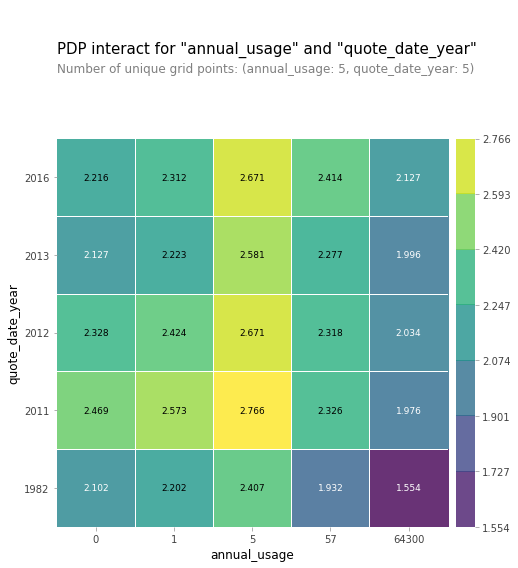

In [0]:
features = ['annual_usage', 'quote_date_year']

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# ASSIGNMENT
- Use the Caterpillar dataset (or _any_ dataset of your choice). **Make these 3 types of visualizations** for model interpretation:
  - Feature Importances
  - Permutation Importances
  - Partial Dependence Plot
- **Share at least 1 of your visualizations on Slack.**
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Improve your scores on Kaggle! Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas. **Share your best features and techniques on Slack.**
- Try the [Skater library](https://oracle.github.io/Skater/index.html), which is an another option to get permutation importances and partial dependence plots.
- Can you figure out partial dependence plots with categorical features?
- Check out the links at the top of this notebook to learn more about how to interpret "black box" machine learning models.